### ROC and AUC Clear Explained

很多学习器是为测试样本产生一个实值或概率预测，然后将这个预测值与一个分类阈值进行比较，若大于阈值则分为正类，否则为反类。例如，神经网络在一般情形下是对每个测试样本预测出一个[0.0，1.0]之间的实值，然后将这个值与阈值0.5进行比较，大于0.5则判为正例，否则为反例。这个阈值设置的好坏，直接决定了学习器的泛化能力。  
在不同的应用任务中，我们可根据任务需求来采用不同的阈值。例如，若我们更重视“查准率”，则可以把阈值设置的大一些，让分类器的预测结果更有把握；若我们更重视“查全率”，则可以把阈值设置的小一些，让分类器预测出更多的正例。因此，阈值设置的好坏，体现了综合考虑学习器在不同任务下的泛化性能的好坏。为了形象的描述这一变化，在此引入ROC曲线，ROC曲线则是从阈值选取角度出发来研究学习器泛化性能的有力工具。

In [1]:
import numpy as np
from scipy.special import expit
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression as logistic
import pandas as pd

#### 我们以 _logistic regression_ 分类器为例来说明。
- 首先我们先产生一批训练数据，假设有一批体重的数据，以及对应的标签。
- 依据训练数据建立logistic 分类器
- 可视化训练数据以及 __logistic 分类器__ 的判定曲线


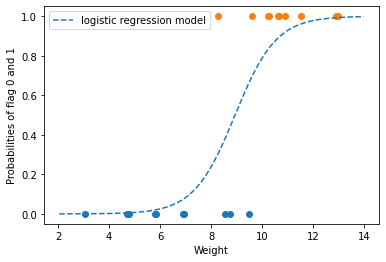

In [2]:
# set random seed and number of samples
np.random.seed(0)
n_data = 10

# generate random samples: normal distribution
# on batch is centered by 5, another is centered by 10, 
# and standard deviation is 2 (variance is 4)
weights_1 = np.random.normal(5, 2, n_data)
weights_2 = np.random.normal(10, 2, n_data)

# train a logistic model to build classifier
train_x = np.hstack((weights_1, weights_2)).reshape(-1, 1)
train_y = np.hstack((np.zeros(n_data), np.ones(n_data)))
clf = logistic()
clf.fit(train_x, train_y)

# plot samples and sigmoid line 
d_min, d_max = min(train_x), max(train_x)
plt.scatter(weights_1, [0] * n_data)
plt.scatter(weights_2, [1] * n_data)
x_test = np.linspace(d_min-1, d_max+1, 300)
y_test = expit(x_test*clf.coef_ + clf.intercept_).ravel()
plt.plot(x_test, y_test, linestyle='dashed', label='logistic regression model')
plt.xlabel('Weight')
plt.ylabel('Probabilities of flag 0 and 1')
plt.legend()

#### 建立混淆矩阵
我们使用同样的生成器，再产生一批测试数据  
使用 __logistic 分类器__ 对测试数据进行分类  
__ROC/AUC__ 的基础是分类后的混淆矩阵，我们尝试建立混淆矩阵观察 __tn, tp, fn, fp__   

,Pred 0,Pred 1
Act 0,9,1
Act 1,2,8


True Negative: 9
False Postive: 1
False Negative: 2
True Postive: 8


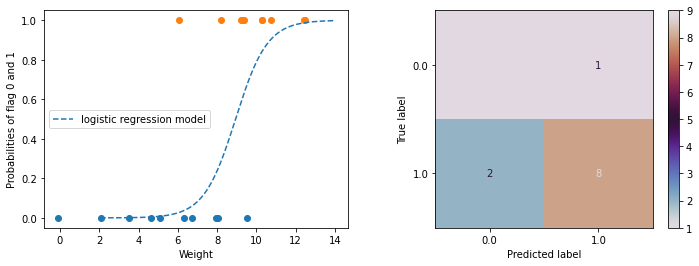

In [3]:
t_weights_1 = np.random.normal(5, 2, n_data)
t_weights_2 = np.random.normal(10, 2, n_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(t_weights_1, [0] * n_data)
ax1.scatter(t_weights_2, [1] * n_data)
ax1.plot(x_test, y_test, linestyle='dashed', label='logistic regression model')
ax1.set_xlabel('Weight')
ax1.set_ylabel('Probabilities of flag 0 and 1')
ax1.legend()

test_x = np.hstack((t_weights_1, t_weights_2)).reshape(-1, 1)
test_y = np.hstack((np.zeros(n_data), np.ones(n_data)))
pred = clf.predict(test_x)
cm = pd.DataFrame(data =confusion_matrix(test_y,pred), columns=['Pred 0', 'Pred 1'], index=['Act 0', 'Act 1'])
display(cm)

plot_confusion_matrix(clf, test_x, test_y, ax=ax2, cmap='twilight')

tn, fp, fn, tp = confusion_matrix(test_y,pred).ravel()
print("True Negative:", tn)
print("False Postive:", fp)
print("False Negative:", fn)
print("True Postive:", tp)

#### 绘制ROC/AUC

缺省情况下，__logistic 分类器__ 会将得分0.5作为判定标准，此时会有一部分 __fn, fp__ 的误判，混淆矩阵就是量化这一误判的工具，如上图所示。 然而有些情况下，我们希望宁可错杀，不要漏过，就可以通过修正0.5这个分类标准来进一步限定对真伪的判定，如提高0.5，那么就有可能将蓝点尽可能的排除。    

__ROC__ 全称是“受试者工作特征”(Receiver OperatingCharacteristic)曲线。我们根据学习器的预测结果，把阈值从0变到最大，即刚开始是把每个样本作为正例进行预测，随着阈值的增大，学习器预测正样例数越来越少，直到最后没有一个样本是正样例。在这一过程中，每次计算出两个重要量的值，分别以它们为横、纵坐标作图，就得到了“ROC曲线”。

__ROC__ 曲线的纵轴是“真正例率”(True Positive Rate, 简称TPR)，横轴是“假正例率”(False Positive Rate,简称FPR)，两者分别定义为：

$$ TPR = \frac{TP}{TP+FN} \tag{1}$$  

$$ FPR = \frac{FP}{TN+FP} \tag{2}$$



我们第一步要做的是计算所有测试数据得到的预测概率，__predict_proba__ 函数

In [4]:
pred_prob = clf.predict_proba(test_x)
print("Class Order: ", clf.classes_)
print("\nProbabilities for each class: ")
print(np.around(pred_prob, 2))

Class Order:  [0. 1.]

Probabilities for each class: 
[[1.   0.  ]
 [0.96 0.04]
 [0.94 0.06]
 [1.   0.  ]
 [0.32 0.68]
 [1.   0.  ]
 [0.99 0.01]
 [1.   0.  ]
 [0.75 0.25]
 [0.78 0.22]
 [0.16 0.84]
 [0.1  0.9 ]
 [0.71 0.29]
 [0.97 0.03]
 [0.39 0.61]
 [0.15 0.85]
 [0.01 0.99]
 [0.01 0.99]
 [0.41 0.59]
 [0.36 0.64]]


绘制 __ROC__ 的过程：依次提高分类的阈值，计算混淆矩阵的 __tn, tp, fn, fp__, 并推导公式（1）（2）， 在ROC图上绘制点  
__AUC__ 则是该曲线所包含的面积  
对角线对应于“随机猜测”模型，而点(0,1)则对应于将所有正例预测为真正例、所有反例预测为真反例的“理想模型”。

Text(0.5, 1.0, 'ROC and AUC')

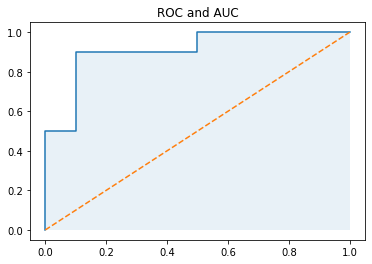

In [5]:
# we just need to check first probability 
prob = pred_prob[:, 1]  # 这里使用可视化的sigmoid曲线表达的1的概率

true_poistive_rate = []
false_positive_rate = []

for threshold in np.linspace(0, 1, 100):
    predx = 1- (prob < threshold).astype(int).astype(int)  # note: prob<threshold indicates 0 not 1
    tn, fp, fn, tp = confusion_matrix(test_y,predx).ravel()
    true_poistive_rate.append(tp/(tp+fn))
    false_positive_rate.append(fp/(fp+tn))
    
plt.plot(false_positive_rate, true_poistive_rate)
plt.fill_between(false_positive_rate, 0, true_poistive_rate, alpha=0.1)
plt.plot([0, 1], [0, 1], linestyle='dashed')
plt.title("ROC and AUC")

#### ROC曲线的意义

- ROC曲线能很容易的查出任意阈值对学习器的泛化性能影响。  
- 有助于选择最佳的阈值。ROC曲线越靠近左上角，模型的查全率就越高。最靠近左上角的ROC曲线上的点是分类错误最少的最好阈值，其假正例和假反例总数最少。  
- 可以对不同的学习器比较性能。将各个学习器的ROC曲线绘制到同一坐标中，直观地鉴别优劣，靠近左上角的ROC曲所代表的学习器准确性最高。  

__优点:__  

- 该方法简单、直观、通过图示可观察分析方法的准确性，并可用肉眼作出判断。ROC曲线将真正例率和假正例率以图示方法结合在一起，可准确反映某种学习器真正例率和假正例率的关系，是检测准确性的综合代表。  
- 在生物信息学上的优点：ROC曲线不固定阈值，允许中间状态的存在，利于使用者结合专业知识，权衡漏诊与误诊的影响，选择一个更加的阈值作为诊断参考值。

#### AUC面积的由来

如果两条ROC曲线没有相交，我们可以根据哪条曲线最靠近左上角哪条曲线代表的学习器性能就最好。但是，实际任务中，情况很复杂，如果两条ROC曲线发生了交叉，则很难一般性地断言谁优谁劣。在很多实际应用中，我们往往希望把学习器性能分出个高低来。在此引入AUC面积。

在进行学习器的比较时，若一个学习器的ROC曲线被另一个学习器的曲线完全“包住”，则可断言后者的性能优于前者；若两个学习器的ROC曲线发生交叉，则难以一般性的断言两者孰优孰劣。此时如果一定要进行比较，则比较合理的判断依据是比较ROC曲线下的面积，即AUC(Area Under ROC Curve)，

#### 我们试着对比random forest 和 logistic regression

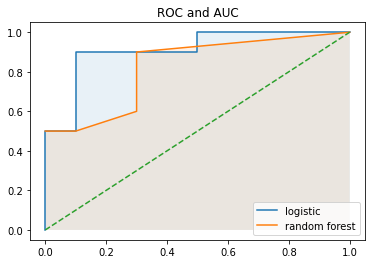

In [6]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier()
clf2.fit(train_x, train_y)
pred_prob = clf2.predict_proba(test_x)

prob = pred_prob[:, 1] 

true_poistive_rate2 = []
false_positive_rate2 = []

for threshold in np.linspace(0, 1, 100):
    predx = 1- (prob < threshold).astype(int).astype(int)  # note: prob<threshold indicates 0 not 1
    tn, fp, fn, tp = confusion_matrix(test_y,predx).ravel()
    true_poistive_rate2.append(tp/(tp+fn))
    false_positive_rate2.append(fp/(fp+tn))
    
plt.plot(false_positive_rate, true_poistive_rate, label='logistic')
plt.fill_between(false_positive_rate, 0, true_poistive_rate, alpha=0.1)
plt.plot(false_positive_rate2, true_poistive_rate2, label='random forest')
plt.fill_between(false_positive_rate2, 0, true_poistive_rate2, alpha=0.1)
plt.plot([0, 1], [0, 1], linestyle='dashed')
plt.title("ROC and AUC")
plt.legend()